In [91]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Bring in the UNSODA data

The database was downloaded from:
https://www.ars.usda.gov/research/software/download/?modeCode=20-36-05-00&softwareid=106

Necessary data was exported from access data base to excell sheets and imported into Pandas

In [116]:
CondData = pd.read_excel('D:\GitHubRepos\WEIRDO\Data\lab_drying_h-k.xlsx')
ThetaData = pd.read_excel('D:\GitHubRepos\WEIRDO\Data\lab_drying_h-t.xlsx')

## Join the data into a single data frame and have a quick look

In [117]:
MergedData = pd.merge(left=ThetaData, right=CondData,on=['code','preshead'])

In [118]:
Data = MergedData.dropna()

In [119]:
Data.set_index('code',inplace=True,drop=False)

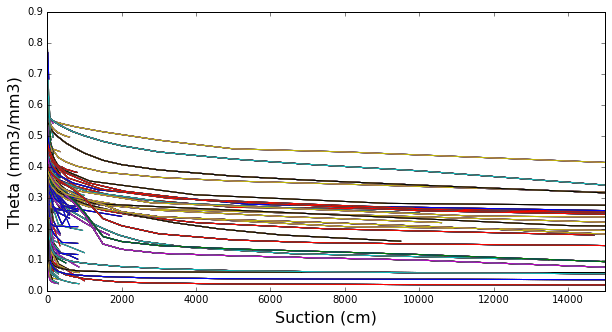

In [456]:
fig = plt.figure(figsize=(10,5))

for soil in Data.index:
    plt.plot(Data.ix[soil,'preshead'],Data.ix[soil,'theta'])
plt.xlim(0,15000)
plt.ylabel('Theta (mm3/mm3)',fontsize=16)
plt.xlabel('Suction (cm)',fontsize=16)

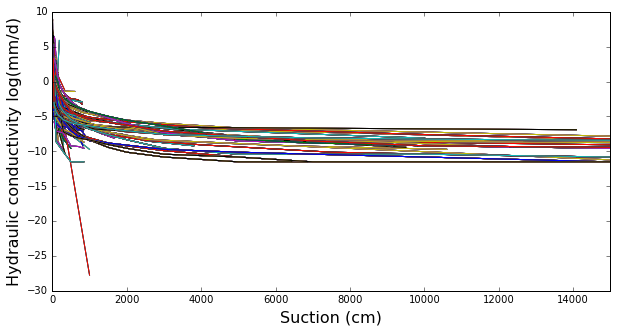

In [460]:
fig = plt.figure(figsize=(10,5))

for soil in Data.index:
    plt.plot(Data.ix[soil,'preshead'],np.log(Data.ix[soil,'conductivity']))
plt.xlim(0,15000)
plt.ylabel('Hydraulic conductivity log(mm/d)',fontsize=16)
plt.xlabel('Suction (cm)',fontsize=16)


## Quite alot of soils have insufficient range in their k and theta measurements to be useful.  
## Filter out anything that has a narrow range of measurements

In [121]:
for soil in Data.index:
    if Data.ix[soil,'preshead'].max() >= 15000 and Data.ix[soil,'preshead'].min() <= 100:
        Data.ix[soil,'FullSet'] = 'true'
    else:
        Data.ix[soil,'FullSet'] = 'false'


In [122]:
SetFilter = Data.ix[:,'FullSet'] == 'true'

In [256]:
FullData = Data.ix[SetFilter,:].copy()

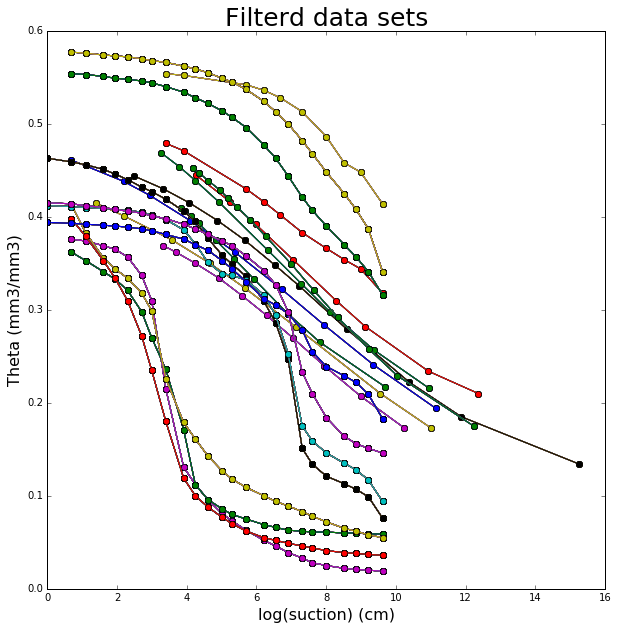

In [461]:
fig = plt.figure(figsize=(10,10))

for soil in FullData.index:
    plt.plot(np.log(FullData.ix[soil,'preshead']),FullData.ix[soil,'theta'],'o-')
plt.ylabel('Theta (mm3/mm3)',fontsize=16)
plt.xlabel('log(suction) (cm)',fontsize=16)
plt.title('Filterd data sets', fontsize=25)


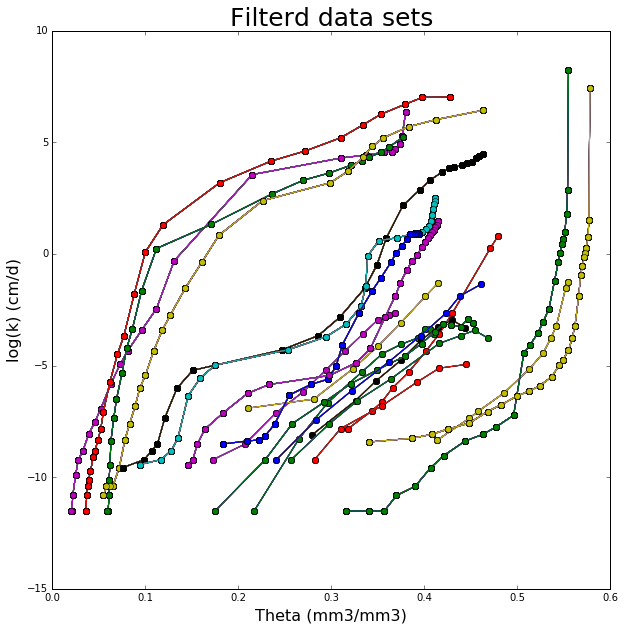

In [462]:
fig = plt.figure(figsize=(10,10))

for soil in FullData.index:
    plt.plot(FullData.ix[soil,'theta'],np.log(FullData.ix[soil,'conductivity']),'o-')
plt.xlabel('Theta (mm3/mm3)',fontsize=16)
plt.ylabel('log(k) (cm/d)',fontsize=16)
plt.title('Filterd data sets', fontsize=25)

## Now we have a data set we can work with lets calculate some things

### Index bits for a start

In [257]:
FullData.sort_values(by=['code','preshead'],inplace=True)

In [258]:
FullData.ix[:,'IntCode']=[x for x in range(FullData.index.size)]

In [259]:
FullData.ix[:,'SampleCode'] = 0

In [261]:
def SampleCount(x):
    ret_val = 1
    if FullData.iloc[x,0] == FullData.iloc[x-1,0]:
        ret_val = FullData.iloc[x-1,6] + 1
    return ret_val

In [262]:
for x in range(FullData.index.size):
    if x == 0:
        FullData.iloc[x,6] = 1
    else:
        FullData.iloc[x,6] = SampleCount(x) 

## Set up some arbitary pore compartments 

### assuming the largest compartments upper diameter is that of the lowest measured pressure and the lower diameter of the smallest pore is zero

In [263]:
FullData.ix[:,'UpperDiameter'] = 3000/FullData.ix[:,'preshead']

In [264]:
FullData.ix[:,'LowerDiameter'] = 0

In [265]:
def LowerDia(x):
    if x == 348:
        ret_val = 0
    else:
        if FullData.iloc[x,0] != FullData.iloc[x+1,0]:
            ret_val = 0
        else:
            ret_val = FullData.iloc[x+1,7]
    return ret_val

In [267]:
FullData.ix[:,'LowerDiameter'] = [LowerDia(x) for x in range(FullData.index.size)]

In [273]:
FullData.ix[:,'ThetaLower'] = [thetaLower(x) for x in range(FullData.index.size)]

### The radius of each more compartment is the mean of its upper and lower diameters

In [268]:
FullData.ix[:,'PoreRadius'] = np.add(FullData.ix[:,'UpperDiameter'],FullData.ix[:,'LowerDiameter'])/4

In [272]:
def thetaLower(x):
    if x == 348:
        ret_val = 0
    else:
        if FullData.iloc[x,0] != FullData.iloc[x+1,0]:
            ret_val = 0
        else:
            ret_val = FullData.iloc[x+1,2]
    return ret_val

### The volume of each pore compartment is derived from theta at its upper and lower boundary

In [275]:
FullData.ix[:,'Volume'] = FullData.ix[:,'theta'] - FullData.ix[:,'ThetaLower']

### The area of individual pore columns in each compartment is calcualted from its radius

In [279]:
FullData.ix[:,'Area'] = np.pi * np.power(FullData.ix[:,'PoreRadius'],2)

### The number of pore columns in each compartment is calculated from its radius and the horizontal area of the compartment, assumed to be equivelent to its pore volume (mm3/mm3)

In [283]:
FullData.ix[:,'Number'] = np.divide(FullData.ix[:,'Volume'],np.divide(FullData.ix[:,'Area'], 1000000000000))

## Now we have all the bits in place to calculate the k curve of the soil from its theta curve.  

This is done as follows

For each pore compartment we estimate a volumetric flow rate per pore column as:

$FlowRate = Cflow * Radius^{3.6}$

The the volumetric flow through that pore compartment as:

$VolumetricFlow = FlowRate * Number$

Then the hydraulic conductivity at a given suction is calculated by summing the conductivity of the pores that are water filled at and below that suction of each pore boundary

In [308]:
FullData.ix[:,'HydraulicConductivity'] = 0

In [375]:
def AccumCond(x):
    if x == 348:
        ret_val = FullData.iloc[x,15]
    else:
        if FullData.iloc[x,0] != FullData.iloc[x+1,0]:
            ret_val = FullData.iloc[x,15]
        else:
            ret_val = FullData.iloc[x,15] + FullData.iloc[x+1,16]
    return ret_val

### The cell below allows trialling of different ways of estimating Cflow and compares the hydraulic conductivity values that result agains those that were observed

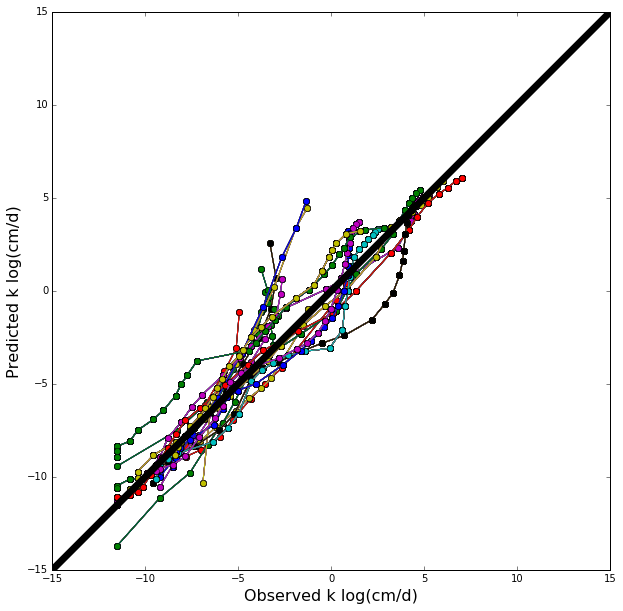

In [524]:
Xradius = [0,1,199,200,1000]
Ccoeff =  [0,0,0.09,0.09]
Xcoeff =  [0,0,-2,-2,-2]
def flowRate(Radius,Coeff):
    Cflow = .01 #+ np.interp(Radius,Xradius,Ycoeff)
    Xflow = 1.6 + 2*np.exp(Radius*-0.008)
    return Cflow * np.power(Radius/1000,Xflow)

FullData.ix[:,'FlowRate'] =  [flowRate(FullData.iloc[x,9],400) for x in range(FullData.index.size)]
FullData.ix[:,'VolumetricFlow'] =  FullData.ix[:,'FlowRate'] * FullData.ix[:,'Number']
for x in reversed(range(FullData.index.size)):
    FullData.iloc[x,16] = AccumCond(x)

fig = plt.figure(figsize=(10,10))

for soil in FullData.index:
    plt.plot(np.log(FullData.ix[soil,'conductivity']),np.log(FullData.ix[soil,'HydraulicConductivity']),'o-')
plt.ylabel('Predicted k log(cm/d)',fontsize=16)
plt.xlabel('Observed k log(cm/d)',fontsize=16)
plt.plot([-15,15],[-15,15],linewidth=7)

Cflow = plt.figure(figsize=(10,5))

## It appears that assuming Cflow is 0.1 for pores with radius less than 1um incraesing to 1 for larger pores works OK??

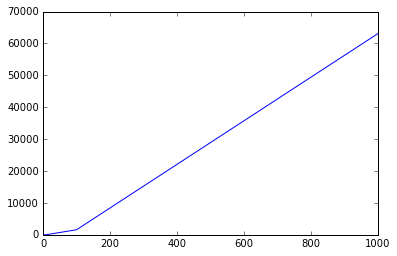

In [511]:
plt.plot([1,10,100,1000],np.power([1,10,100,1000],1.6))